In [4]:
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import optuna

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

full_train_data = datasets.ImageFolder("chest_Xray/train", transform=transform)
train_size = int(0.8 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, val_data = random_split(full_train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

test_data = datasets.ImageFolder("chest_Xray/test", transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")

Train: 4172 | Val: 1044 | Test: 624


In [5]:
def create_model(trial):
    weights = MobileNet_V2_Weights.DEFAULT
    model = models.mobilenet_v2(weights=weights)
    for param in model.features.parameters():
        param.requires_grad = False
    num_features = model.classifier[1].in_features
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_features, 2)
    )
    return model

In [6]:
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = create_model(trial).to(device)
    
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    for epoch in range(5): 
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return f1_score(y_true, y_pred, pos_label=1)

In [7]:
study = optuna.create_study(
    direction="maximize",
    study_name="mobilenet_cnn_f1",
    storage="sqlite:///optuna_mobilenet_f1.db",
    load_if_exists=True
)

if len([t for t in study.trials if t.state.name == "COMPLETE"]) >= 20:
    print("Assez de trials déjà faits, on saute l'optimisation.")
else:
    study.optimize(objective, n_trials=5)

[I 2025-05-31 12:52:46,354] A new study created in RDB with name: mobilenet_cnn_f1
[I 2025-05-31 13:21:57,315] Trial 0 finished with value: 0.8390022675736961 and parameters: {'dropout_rate': 0.21214140079334945, 'lr': 0.00023852822444161834, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.8390022675736961.
[I 2025-05-31 13:51:13,930] Trial 1 finished with value: 0.9602693602693603 and parameters: {'dropout_rate': 0.34458684674443557, 'lr': 0.00045633290820420053, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.9602693602693603.
[I 2025-05-31 14:19:34,041] Trial 2 finished with value: 0.8484149855907781 and parameters: {'dropout_rate': 0.21196848622491216, 'lr': 7.940224497072515e-05, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.9602693602693603.
[I 2025-05-31 14:42:15,889] Trial 3 finished with value: 0.9646430953969313 and parameters: {'dropout_rate': 0.38062634376609206, 'lr': 0.003968452590508034, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.9646430953969313.
[I

Best hyperparameters: {'dropout_rate': 0.38062634376609206, 'lr': 0.003968452590508034, 'optimizer': 'Adam'}
Epoch 1 - Loss: 39.8317
Epoch 2 - Loss: 33.5618
Epoch 3 - Loss: 27.6634
Epoch 4 - Loss: 27.6559
Epoch 5 - Loss: 30.1855
Epoch 6 - Loss: 28.5610
Epoch 7 - Loss: 28.6137
Epoch 8 - Loss: 28.8078
Epoch 9 - Loss: 27.7272
Epoch 10 - Loss: 31.4762


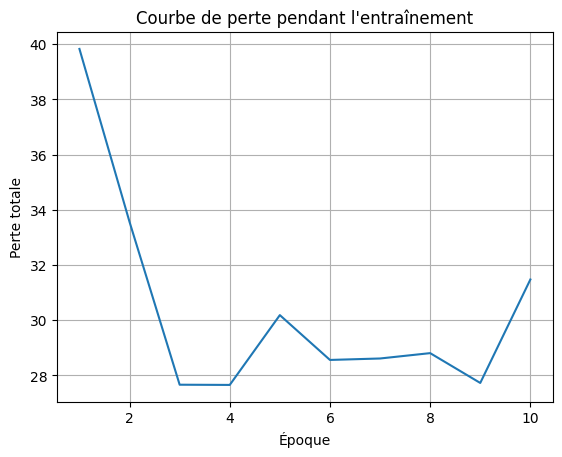

In [8]:
trial = study.best_trial
print("Best hyperparameters:", trial.params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = create_model(trial).to(device)

full_loader = DataLoader(full_train_data, batch_size=32, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = getattr(optim, trial.params["optimizer"])(best_model.parameters(), lr=trial.params["lr"])
losses = []

for epoch in range(10):
    best_model.train()
    total_loss = 0.0
    for inputs, labels in full_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

plt.plot(range(1, 11), losses)
plt.xlabel("Époque")
plt.ylabel("Perte totale")
plt.title("Courbe de perte pendant l'entraînement")
plt.grid(True)
plt.show()

In [9]:
def evaluate_on_test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    print("\n--- Évaluation finale sur les données de test ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=test_data.classes))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

evaluate_on_test(best_model, test_loader)


--- Évaluation finale sur les données de test ---
Accuracy: 0.8157
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.92      0.56      0.69       234
   PNEUMONIA       0.78      0.97      0.87       390

    accuracy                           0.82       624
   macro avg       0.85      0.76      0.78       624
weighted avg       0.84      0.82      0.80       624

Confusion Matrix:
 [[130 104]
 [ 11 379]]


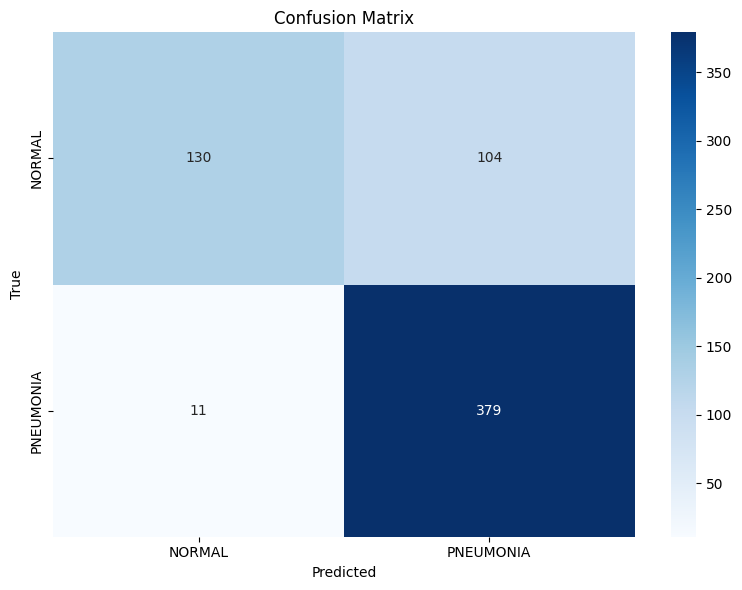

Results saved to parquet files in the 'results_mobilenet' directory


In [12]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import os

import matplotlib.pyplot as plt

# Function to evaluate and save results
def evaluate_and_save_results(model, data_loader, save_path='results_mobilenet'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Create and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=test_data.classes, 
                yticklabels=test_data.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f"{save_path}/confusion_matrix.png", dpi=300)
    plt.show()
    
    # Create classification report dataframe
    report = classification_report(y_true, y_pred, 
                                  target_names=test_data.classes, 
                                  output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    # Save reports as parquet
    report_df.to_parquet(f"{save_path}/classification_report.parquet")
    
    # Also save confusion matrix as parquet
    cm_df = pd.DataFrame(cm, 
                        index=test_data.classes,
                        columns=test_data.classes)
    cm_df.to_parquet(f"{save_path}/confusion_matrix.parquet")
    
    return report_df, cm_df

# Create save directory if it doesn't exist
os.makedirs("results_mobilenet", exist_ok=True)

# Run evaluation and save results
report_df, cm_df = evaluate_and_save_results(best_model, test_loader)
print("Results saved to parquet files in the 'results_mobilenet' directory")